In [24]:
import math
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

# Architecture

More complex structure to capture more patterns.

In [41]:
# Generator
class Generator(nn.Module):
    def __init__(self, img_dim, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),   # help stablizing the learning process by input layer normalization
            nn.ReLU(True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

    def sample(self, B):
        x = torch.randn(B, self.latent_dim).to(device)
        x = self.forward(x)
        return x

In [42]:
# Discirminator
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [35]:
def generateSamples(generator, num_samples=18):
    x = generator.sample(num_samples)
    return x

def plotSamples(x, M=6, N=3):
    fig, ax = plt.subplots(N, M, figsize=(M, N * 1.3), sharex=True, sharey=True)
    for i in range(N):
        for j in range(M):
            ax[i, j].imshow(x[i * 3 + j].permute(1, 2, 0), cmap="gray")
    plt.show()

# Hyper-parameter Setting

In [65]:
img_dim = 28 * 28
num_epochs = 30
batch_size = 16
latent_dim = 100
gen_lr = 0.00015
dis_lr = 0.0002

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device using: {device}")

Device using: cpu


The generator training can be stabilized at a smaller range of values when the learning rate is raised to 0.0002, but the discriminator loss rises relatively quickly, so I adjusted the learning rate to 0.00015 to balance the learning intensity and optimize the generation effect.

# Training

In [66]:
generator = Generator(img_dim, latent_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

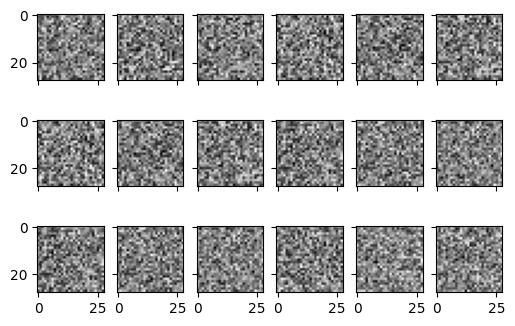

In [62]:
x_fake = generator.sample(18).view(-1, 1, 28, 28).cpu().detach()
plotSamples(x_fake)

In [67]:
opt_gen = optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
opt_dis = optim.Adam(discriminator.parameters(), lr=dis_lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()
d_history = []
g_history = []

In [68]:
for epoch in range(num_epochs):
    loss_d = 0.0
    loss_g = 0.0
    n = 0
    for batch_idx, data in enumerate(trainloader):
        X, _ = data
        X = X.view(-1, img_dim)
        X = X.to(device).float()

        X_fake = torch.randn(batch_size, latent_dim).to(device)
        X_fake = generator(X_fake)
        d_loss = criterion(discriminator(X), torch.ones(batch_size, 1).to(device)) + criterion(discriminator(X_fake), torch.zeros(batch_size, 1).to(device))
        opt_dis.zero_grad()
        d_loss.backward(retain_graph=True)
        opt_dis.step()

        g_loss = criterion(discriminator(X_fake), torch.ones(batch_size, 1).to(device))
        opt_gen.zero_grad()
        g_loss.backward(retain_graph=True)
        opt_gen.step()

        loss_d += d_loss.item()
        loss_g += g_loss.item()
        n += 1

    d_history.append(loss_d / n)
    g_history.append(loss_g / n)
    print(f"Epoch {epoch} with discriminator loss: {loss_d / n} and generator loss: {loss_g / n}")

Epoch 0 with discriminator loss: 0.9259850828170776 and generator loss: 1.491938838704427
Epoch 1 with discriminator loss: 1.0367694254875184 and generator loss: 1.2710206243515014
Epoch 2 with discriminator loss: 1.1585885052045186 and generator loss: 1.0759730417569477
Epoch 3 with discriminator loss: 1.2236146048069 and generator loss: 0.9713429789225261
Epoch 4 with discriminator loss: 1.255534805727005 and generator loss: 0.9173860329469045
Epoch 5 with discriminator loss: 1.2751717681407928 and generator loss: 0.8829876818656921
Epoch 6 with discriminator loss: 1.2933111950556437 and generator loss: 0.8569113435586293
Epoch 7 with discriminator loss: 1.3055199760278067 and generator loss: 0.8374766861915588
Epoch 8 with discriminator loss: 1.3113607032775878 and generator loss: 0.8268135915279389
Epoch 9 with discriminator loss: 1.3156309581756591 and generator loss: 0.8179943922042847
Epoch 10 with discriminator loss: 1.3186704193115235 and generator loss: 0.8157772275924683
Epo

# Results plotting

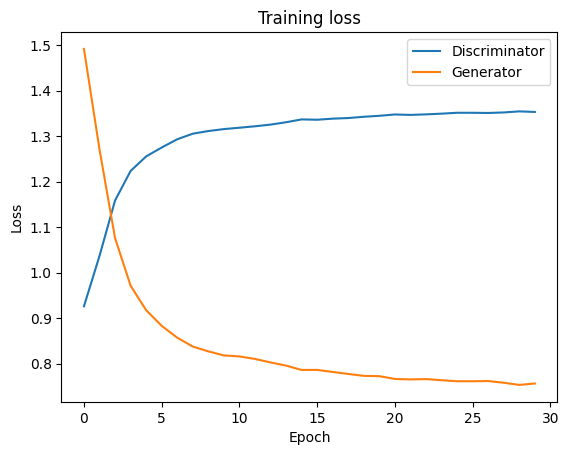

In [69]:
# Training Loss
plt.plot(d_history, label="Discriminator")
plt.plot(g_history, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.legend()
plt.show()

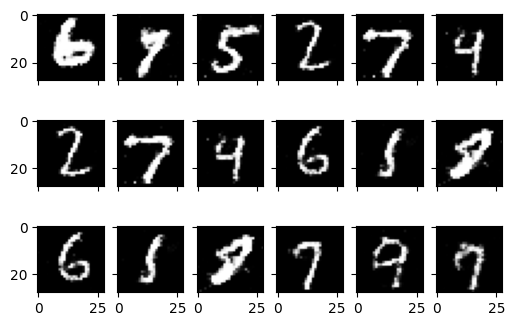

In [70]:
x_fake = generator.sample(18).view(-1, 1, 28, 28).cpu().detach()
fig, ax = plt.subplots(3, 6, figsize=(6, 3 * 1.3), sharex=True, sharey=True)
for i in range(3):
    for j in range(6):
        ax[i, j].imshow(x_fake[i * 3 + j].permute(1, 2, 0), cmap="gray")
plt.show()